In [1]:
import pynucastro as pyna
from pynucastro.rates import ReacLibRate, TabularRate

In [2]:
DO_DERIVED_RATES = True

In [3]:
reaclib_lib = pyna.ReacLibLibrary()
weak_lib = pyna.TabularLibrary()

In [4]:
# these are the nuclei we have in subch_simple

all_reactants = ["p",
                 "he4", "c12", "o16", "ne20", "mg24", "si28", "s32",
                 "ar36", "ca40", "ti44", "cr48", "fe52", "ni56",
                 "cu59", "zn60",
                 "al27", "p31", "cl35", "k39", "sc43", "v47", "mn51", "co55",
                 "n13", "n14", "f18", "ne21", "na22", "na23"]

In [5]:
# create a library of ReacLib rates

core_lib = reaclib_lib.linking_nuclei(all_reactants)

# in this list, we have the reactants, the actual reactants,
# and modified products that we will use instead

other_rates = [("c12(c12,n)mg23", "mg24"),
               ("o16(o16,n)s31", "s32"),
               ("o16(c12,n)si27", "si28")]

for r, mp in other_rates:
    _r = reaclib_lib.get_rate_by_name(r)
    _r.modify_products(mp)
    core_lib.add_rate(_r)

# finally, the aprox nets don't include the reverse rates for
# C12+C12, C12+O16, and O16+O16, so remove those

for r in core_lib.get_rates():
    if sorted(r.products) in [[pyna.Nucleus("c12"), pyna.Nucleus("c12")],
                              [pyna.Nucleus("c12"), pyna.Nucleus("o16")],
                              [pyna.Nucleus("o16"), pyna.Nucleus("o16")]]:
        core_lib.remove_rate(r)

# C12+Ne20 and reverse
# (a,g) links between Na23 and Al27
# (a,g) links between Al27 and P31

rates_to_remove = ["p31(p,c12)ne20",
                   "si28(a,c12)ne20",
                   "ne20(c12,p)p31",
                   "ne20(c12,a)si28",
                   "na23(a,g)al27",
                   "al27(g,a)na23",
                   "al27(a,g)p31",
                   "p31(g,a)al27"]

for r in rates_to_remove:
    print("removing: ", r)
    _r = core_lib.get_rate_by_name(r)
    core_lib.remove_rate(_r)

removing:  p31(p,c12)ne20
removing:  si28(a,c12)ne20
removing:  ne20(c12,p)p31
removing:  ne20(c12,a)si28
removing:  na23(a,g)al27
removing:  al27(g,a)na23
removing:  al27(a,g)p31
removing:  p31(g,a)al27


In [6]:
# now create a list of iron group nuclei and find both the
# ReacLib and weak / tabular rates linking these.

iron_peak = ["n", "p", "he4",
             "mn51", "mn55",
             "fe52", "fe53", "fe54", "fe55", "fe56",
             "co55", "co56", "co57",
             "ni56", "ni57", "ni58",
             "cu59", "zn60"]

iron_reaclib = reaclib_lib.linking_nuclei(iron_peak)

iron_weak_lib = weak_lib.linking_nuclei(iron_peak)

In [7]:
# add the libraries

all_lib = core_lib + iron_reaclib + iron_weak_lib

In [8]:
if DO_DERIVED_RATES:
    rates_to_derive = []
    for r in all_lib.get_rates():
        if r.reverse:
            # this rate was computed using detailed balance, regardless
            # of whether Q < 0 or not.  We want to remove it and then
            # recompute it
            rates_to_derive.append(r)

    # now for each of those derived rates, look to see if the pair exists

    for r in rates_to_derive:
        fr = all_lib.get_rate_by_nuclei(r.products, r.reactants)
        if fr:
            print(f"modifying {r} from {fr}")
            all_lib.remove_rate(r)
            d = pyna.DerivedRate(rate=fr, compute_Q=False, use_pf=True)
            all_lib.add_rate(d)

# we will have duplicate rates -- we want to remove any ReacLib rates
# that we have tabular rates for

dupes = all_lib.find_duplicate_links()

rates_to_remove = []
for d in dupes:
    for r in d:
        if isinstance(r, ReacLibRate):
            rates_to_remove.append(r)

for r in rates_to_remove:
    all_lib.remove_rate(r)

modifying N13 ⟶ p + C12 from C12 + p ⟶ N13 + 𝛾
modifying O16 ⟶ He4 + C12 from C12 + He4 ⟶ O16 + 𝛾
modifying F18 ⟶ He4 + N14 from N14 + He4 ⟶ F18 + 𝛾
modifying Ne20 ⟶ He4 + O16 from O16 + He4 ⟶ Ne20 + 𝛾
modifying Na22 ⟶ p + Ne21 from Ne21 + p ⟶ Na22 + 𝛾
modifying Na22 ⟶ He4 + F18 from F18 + He4 ⟶ Na22 + 𝛾
modifying Mg24 ⟶ p + Na23 from Na23 + p ⟶ Mg24 + 𝛾
modifying Mg24 ⟶ He4 + Ne20 from Ne20 + He4 ⟶ Mg24 + 𝛾
modifying Si28 ⟶ p + Al27 from Al27 + p ⟶ Si28 + 𝛾
modifying Si28 ⟶ He4 + Mg24 from Mg24 + He4 ⟶ Si28 + 𝛾
modifying S32 ⟶ p + P31 from P31 + p ⟶ S32 + 𝛾
modifying S32 ⟶ He4 + Si28 from Si28 + He4 ⟶ S32 + 𝛾
modifying Cl35 ⟶ He4 + P31 from P31 + He4 ⟶ Cl35 + 𝛾
modifying Ar36 ⟶ p + Cl35 from Cl35 + p ⟶ Ar36 + 𝛾
modifying Ar36 ⟶ He4 + S32 from S32 + He4 ⟶ Ar36 + 𝛾
modifying K39 ⟶ He4 + Cl35 from Cl35 + He4 ⟶ K39 + 𝛾
modifying Ca40 ⟶ p + K39 from K39 + p ⟶ Ca40 + 𝛾
modifying Ca40 ⟶ He4 + Ar36 from Ar36 + He4 ⟶ Ca40 + 𝛾
modifying Sc43 ⟶ He4 + K39 from K39 + He4 ⟶ Sc43 + 𝛾
modifying Ti44 

In [9]:
# combine all three libraries into a single network

net = pyna.AmrexAstroCxxNetwork(libraries=[all_lib],
                                symmetric_screening=False)

In [10]:
# now we approximate some (alpha, p)(p, gamma) links

net.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47"])
net.remove_nuclei(["cl35", "k39", "sc43", "v47"])

using approximate rate S32 + He4 ⟶ Ar36 + 𝛾
using approximate rate Ar36 ⟶ S32 + He4
using approximate rate Ar36 + He4 ⟶ Ca40 + 𝛾
using approximate rate Ca40 ⟶ Ar36 + He4
using approximate rate Ca40 + He4 ⟶ Ti44 + 𝛾
using approximate rate Ti44 ⟶ Ca40 + He4
using approximate rate Ti44 + He4 ⟶ Cr48 + 𝛾
using approximate rate Cr48 ⟶ Ti44 + He4
removing rate S32 + He4 ⟶ Ar36 + 𝛾
removing rate S32 + He4 ⟶ p + Cl35
removing rate Cl35 + p ⟶ Ar36 + 𝛾
removing rate Ar36 ⟶ He4 + S32
removing rate Ar36 ⟶ p + Cl35
removing rate Cl35 + p ⟶ He4 + S32
removing rate Ar36 + He4 ⟶ Ca40 + 𝛾
removing rate Ar36 + He4 ⟶ p + K39
removing rate K39 + p ⟶ Ca40 + 𝛾
removing rate Ca40 ⟶ He4 + Ar36
removing rate Ca40 ⟶ p + K39
removing rate K39 + p ⟶ He4 + Ar36
removing rate Ca40 + He4 ⟶ Ti44 + 𝛾
removing rate Ca40 + He4 ⟶ p + Sc43
removing rate Sc43 + p ⟶ Ti44 + 𝛾
removing rate Ti44 ⟶ He4 + Ca40
removing rate Ti44 ⟶ p + Sc43
removing rate Sc43 + p ⟶ He4 + Ca40
removing rate Ti44 + He4 ⟶ Cr48 + 𝛾
removing rate Ti44

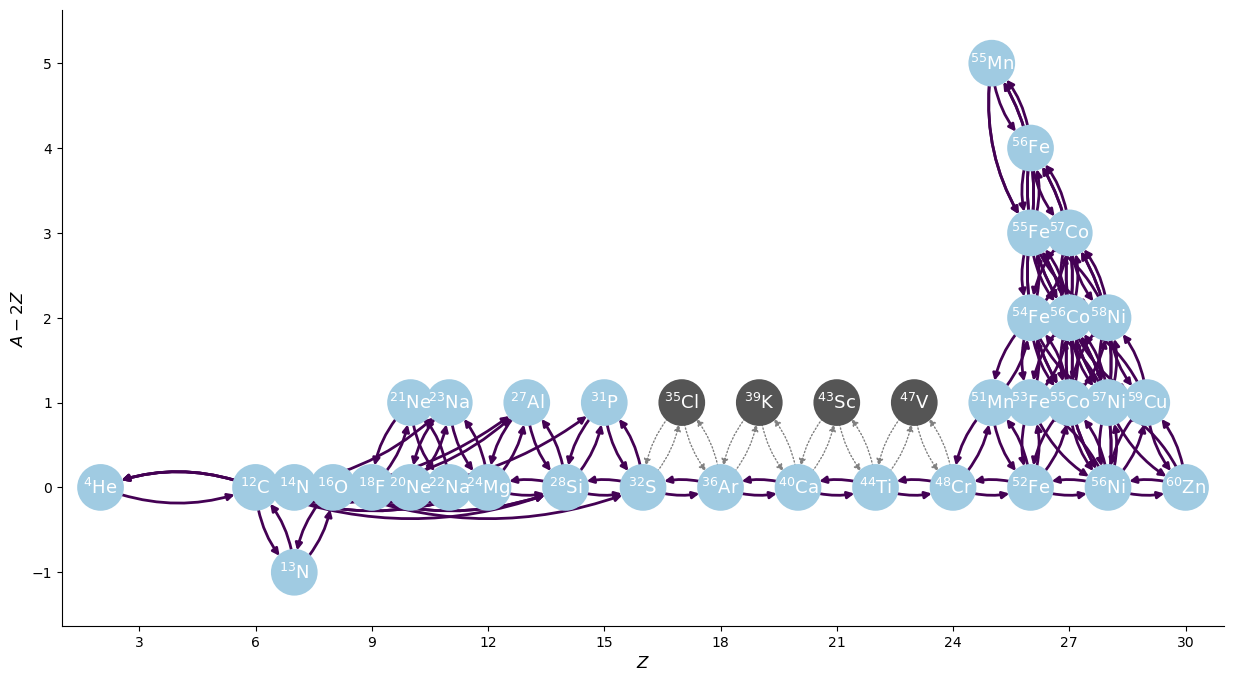

In [11]:
fig = net.plot(rotated=True, curved_edges=True, size=(1500, 800), hide_xp=True, hide_xalpha=True)

In [12]:
rho = 1.e8
T = 4.e9
comp = pyna.Composition(net.unique_nuclei)
comp.set_equal()

/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N14 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))


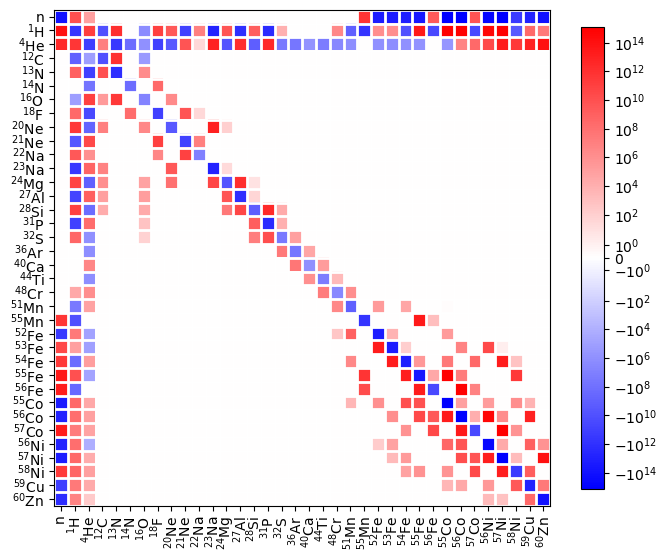

In [13]:
fig = net.plot_jacobian(rho, T, comp, rate_scaling=1.e15)

In [14]:
net.make_nse_protons(48)

modifying p_Mn51__Fe52 to use NSE protons
modifying Fe52__p_Mn51__derived to use NSE protons
modifying p_Co55__Ni56 to use NSE protons
modifying Ni56__p_Co55__derived to use NSE protons
modifying p_Cu59__Zn60 to use NSE protons
modifying Zn60__p_Cu59__derived to use NSE protons
modifying He4_Cr48__p_Mn51 to use NSE protons
modifying p_Mn51__He4_Cr48__derived to use NSE protons
modifying He4_Fe52__p_Co55 to use NSE protons
modifying p_Co55__He4_Fe52__derived to use NSE protons
modifying p_Cu59__He4_Ni56 to use NSE protons
modifying He4_Ni56__p_Cu59__derived to use NSE protons
modifying p_Mn55__Fe56 to use NSE protons
modifying Fe56__p_Mn55__derived to use NSE protons
modifying p_Fe54__Co55 to use NSE protons
modifying Co55__p_Fe54__derived to use NSE protons
modifying p_Fe55__Co56 to use NSE protons
modifying Co56__p_Fe55__derived to use NSE protons
modifying p_Fe56__Co57 to use NSE protons
modifying Co57__p_Fe56__derived to use NSE protons
modifying p_Co56__Ni57 to use NSE protons
modi

In [15]:
# need to redo comp, since the nuclei changed

In [16]:
comp = pyna.Composition(net.unique_nuclei)
comp.set_equal()

/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: p_nse partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N14 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(User

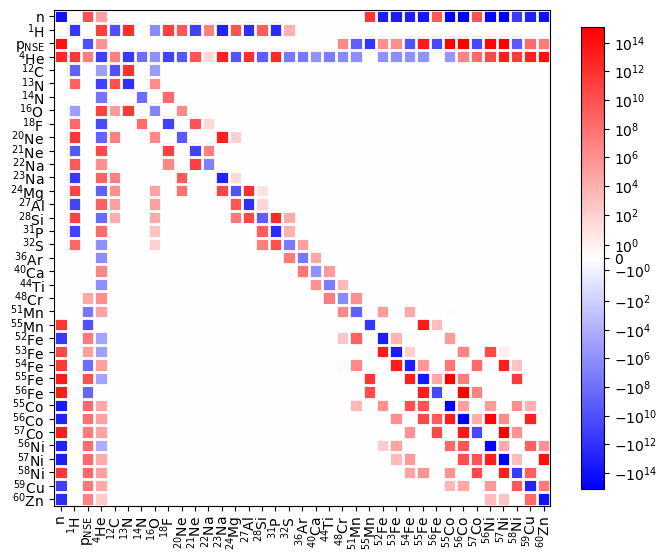

In [17]:
fig2 = net.plot_jacobian(rho, T, comp, rate_scaling=1.e15)

In [18]:
net.unique_nuclei

[n,
 p,
 p_nse,
 He4,
 C12,
 N13,
 N14,
 O16,
 F18,
 Ne20,
 Ne21,
 Na22,
 Na23,
 Mg24,
 Al27,
 Si28,
 P31,
 S32,
 Ar36,
 Ca40,
 Ti44,
 Cr48,
 Mn51,
 Mn55,
 Fe52,
 Fe53,
 Fe54,
 Fe55,
 Fe56,
 Co55,
 Co56,
 Co57,
 Ni56,
 Ni57,
 Ni58,
 Cu59,
 Zn60]

In [19]:
comp.get_molar()

{n: 0.02702702702702703,
 p: 0.02702702702702703,
 p_nse: 0.02702702702702703,
 He4: 0.006756756756756757,
 C12: 0.0022522522522522522,
 N13: 0.002079002079002079,
 N14: 0.0019305019305019305,
 O16: 0.0016891891891891893,
 F18: 0.0015015015015015015,
 Ne20: 0.0013513513513513514,
 Ne21: 0.0012870012870012872,
 Na22: 0.0012285012285012285,
 Na23: 0.0011750881316098707,
 Mg24: 0.0011261261261261261,
 Al27: 0.001001001001001001,
 Si28: 0.0009652509652509653,
 P31: 0.0008718395815170009,
 S32: 0.0008445945945945946,
 Ar36: 0.0007507507507507507,
 Ca40: 0.0006756756756756757,
 Ti44: 0.0006142506142506142,
 Cr48: 0.0005630630630630631,
 Mn51: 0.0005299417064122947,
 Mn55: 0.0004914004914004914,
 Fe52: 0.0005197505197505198,
 Fe53: 0.0005099439061703213,
 Fe54: 0.0005005005005005005,
 Fe55: 0.0004914004914004914,
 Fe56: 0.00048262548262548264,
 Co55: 0.0004914004914004914,
 Co56: 0.00048262548262548264,
 Co57: 0.000474158368895211,
 Ni56: 0.00048262548262548264,
 Ni57: 0.000474158368895211,
 

In [20]:
fig2.savefig("jac_nse_protons.png")

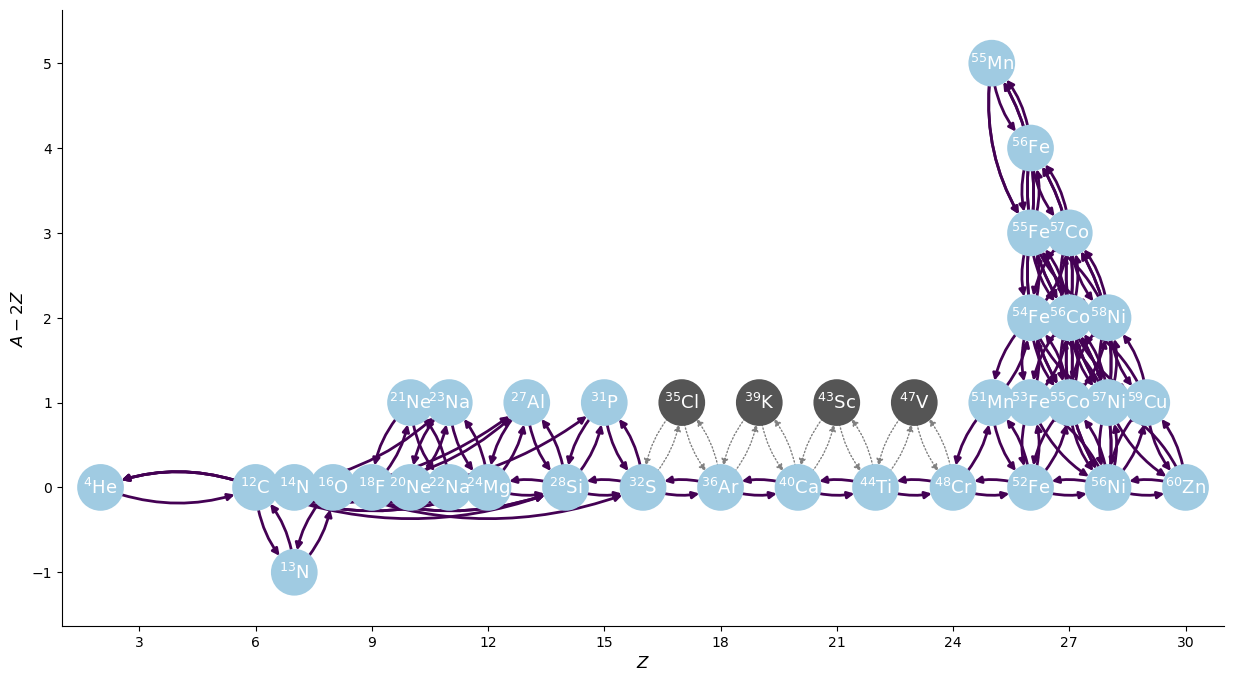

In [21]:
fig = net.plot(rotated=True, curved_edges=True, size=(1500, 800), hide_xp=True, hide_xalpha=True)

In [23]:
net.write_network()

/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N14 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: p_nse partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(User